In [1]:
import pandas as pd

df = pd.read_csv("Airline_Delay_Cause.csv")

df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [2]:
df.shape
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171666 non-null  int64  
 1   month                171666 non-null  int64  
 2   carrier              171666 non-null  object 
 3   carrier_name         171666 non-null  object 
 4   airport              171666 non-null  object 
 5   airport_name         171666 non-null  object 
 6   arr_flights          171426 non-null  float64
 7   arr_del15            171223 non-null  float64
 8   carrier_ct           171426 non-null  float64
 9   weather_ct           171426 non-null  float64
 10  nas_ct               171426 non-null  float64
 11  security_ct          171426 non-null  float64
 12  late_aircraft_ct     171426 non-null  float64
 13  arr_cancelled        171426 non-null  float64
 14  arr_diverted         171426 non-null  float64
 15  arr_delay        

In [3]:
df.columns = [c.strip().lower() for c in df.columns]
df.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [4]:
num_cols = df.select_dtypes(include="number").columns
obj_cols = df.select_dtypes(include="object").columns

df[num_cols] = df[num_cols].fillna(0)          
df[obj_cols] = df[obj_cols].fillna("Unknown")  

df.isnull().sum().sort_values(ascending=False).head()

year              0
security_ct       0
security_delay    0
nas_delay         0
weather_delay     0
dtype: int64

In [5]:
# make sure delayed flights never exceed total flights by capping at the smaller value
if "arr_del15" in df.columns and "arr_flights" in df.columns:
    df["arr_del15"] = df[["arr_del15", "arr_flights"]].min(axis=1)

In [6]:
# calculate percent of flights delayed, replacing 0 flights with NA to avoid division errors
df["delay_rate"] = df["arr_del15"] / df["arr_flights"].replace(0, pd.NA)

# calculate average delay minutes per delayed flight, replacing 0 delayed flights with NA for safety
df["avg_delay_per_delayed_flight"] = df["arr_delay"] / df["arr_del15"].replace(0, pd.NA)

In [7]:
# List of all delay cause columns to combine into a single total.
delay_cols = ["carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay"]

# Sum all cause-specific delay minutes across each row to get total delay minutes per record.
df["total_delay_minutes"] = df[delay_cols].sum(axis=1)


In [8]:
# show what portion of total delay time comes from each delay cause
for col in delay_cols:
    prop_col = col.replace("_delay", "_delay_prop")
    df[prop_col] = df[col] / df["total_delay_minutes"].replace(0, pd.NA)

In [10]:
df.to_csv("Airline_Delay_Cause_clean.csv", index=False)

In [11]:
# making visualizations below

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Airline_Delay_Cause_Clean.csv")

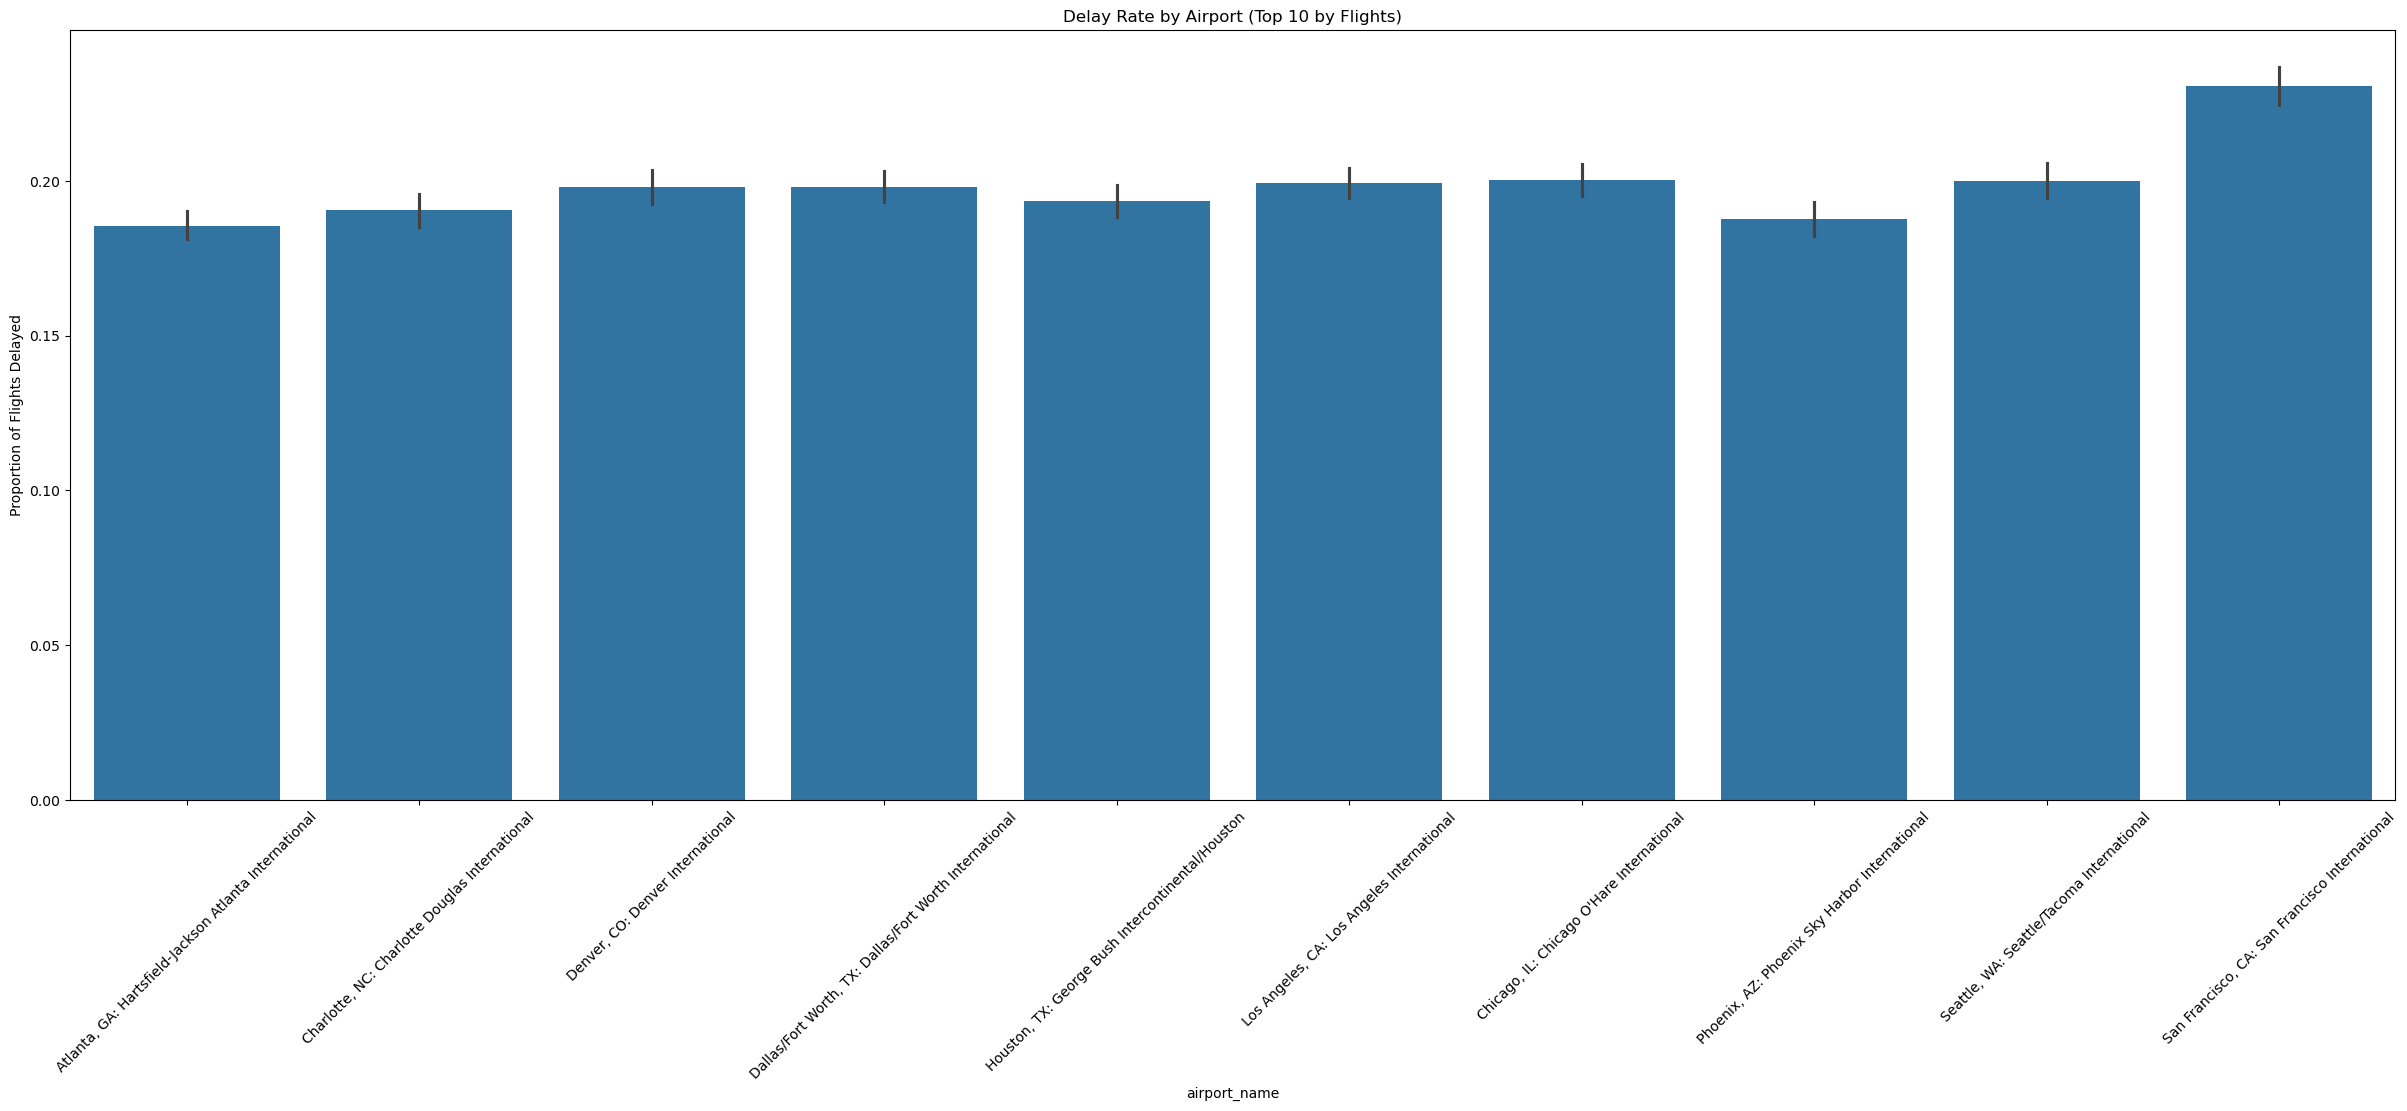

In [20]:
top_airports = df.groupby("airport_name")["arr_flights"].sum().sort_values(ascending=False).head(10).index

plt.figure(figsize=(30,10))
sns.barplot(
    data=df[df["airport_name"].isin(top_airports)],
    x="airport_name", y="delay_rate"
)
plt.xticks(rotation=45)
plt.title("Delay Rate by Airport (Top 10 by Flights)")
plt.ylabel("Proportion of Flights Delayed")
plt.show()

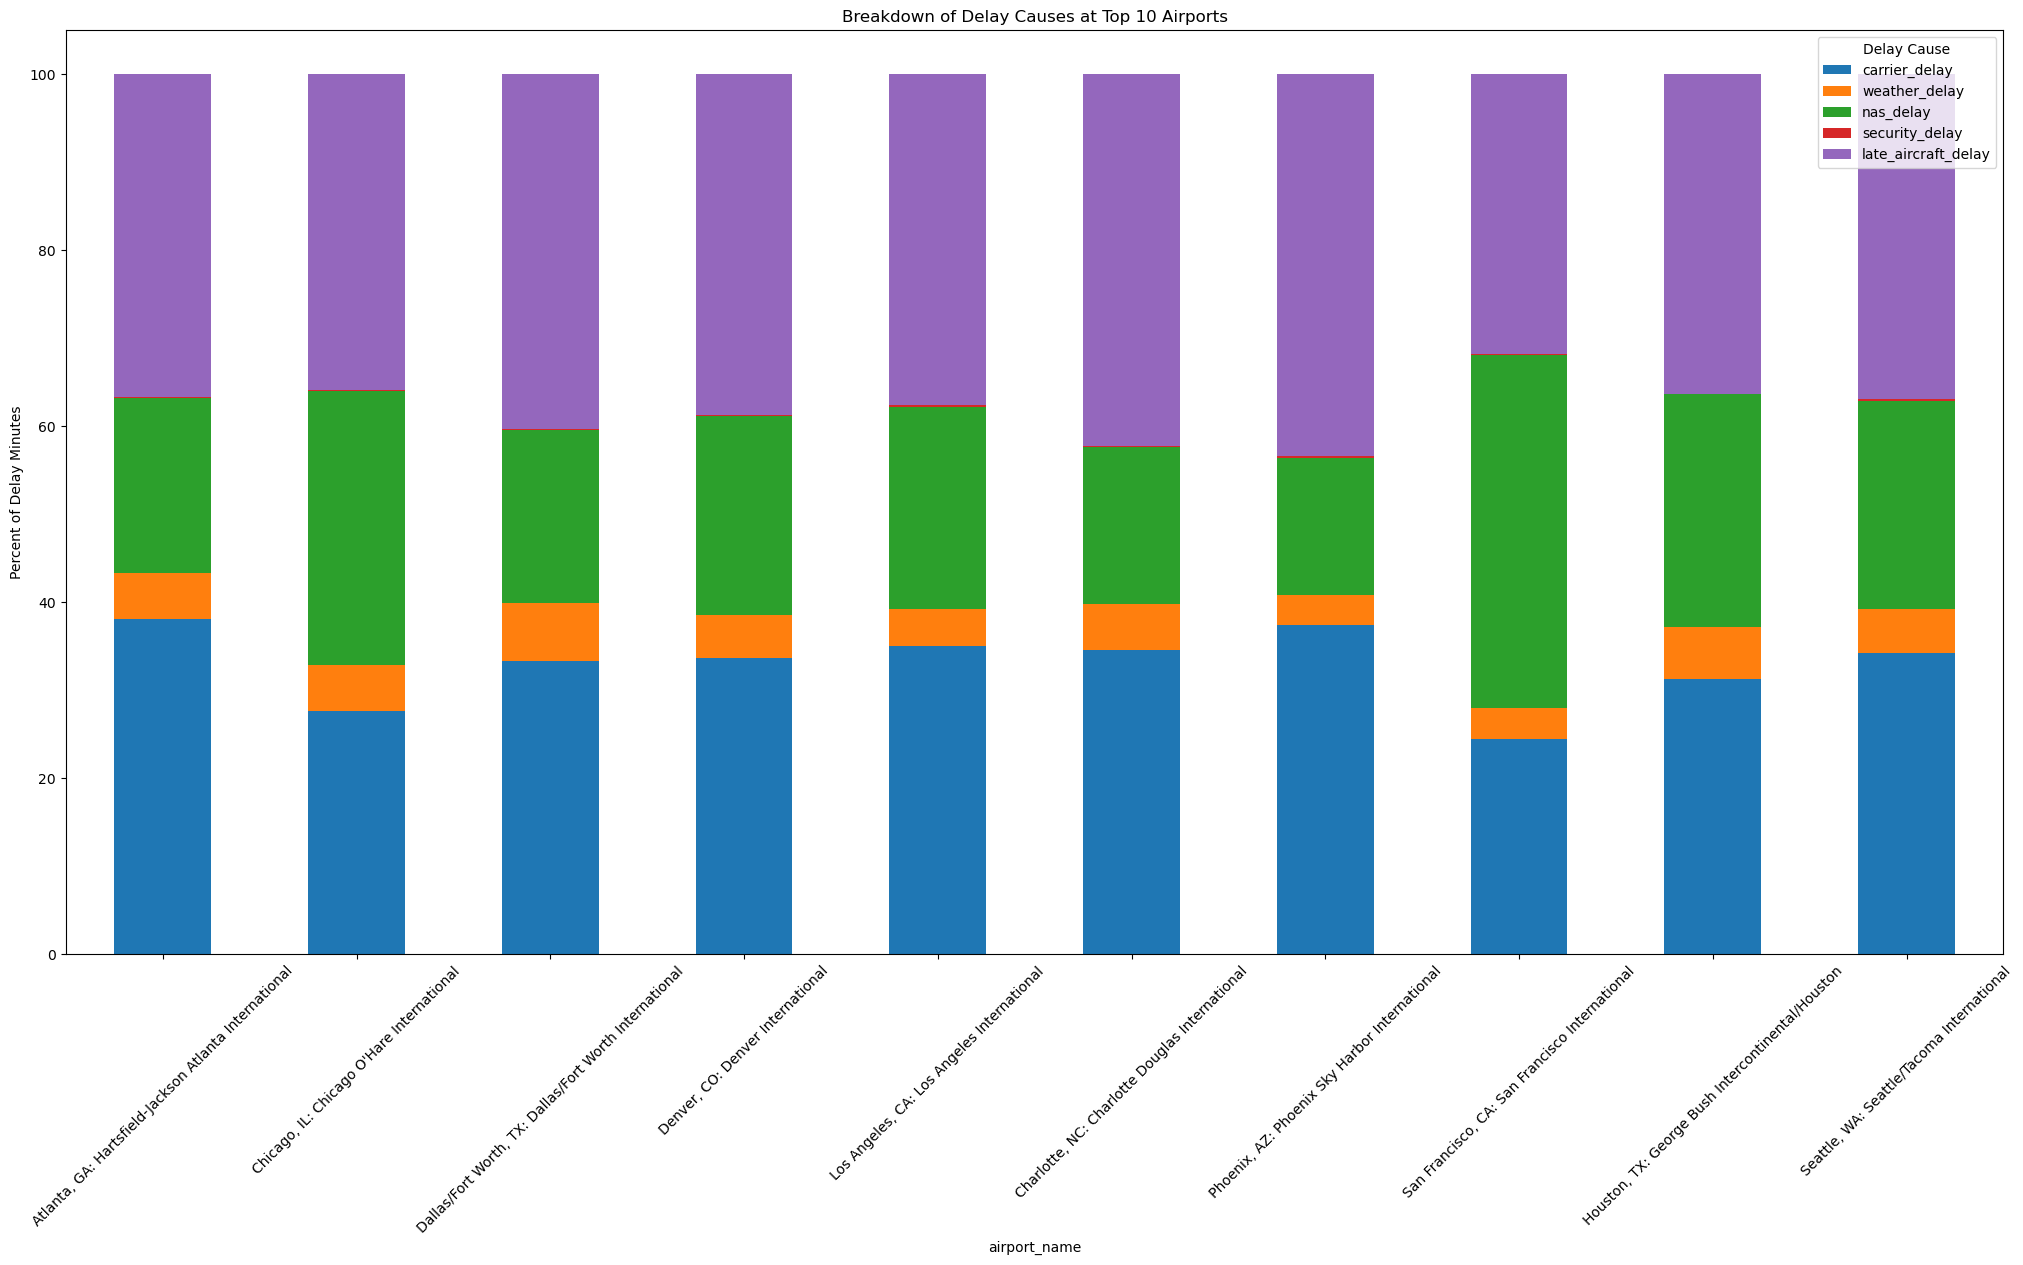

In [21]:
cause_cols = ["carrier_delay","weather_delay","nas_delay","security_delay","late_aircraft_delay"]

cause_sums = df.groupby("airport_name")[cause_cols].sum()
cause_sums_percent = cause_sums.div(cause_sums.sum(axis=1), axis=0) * 100

cause_sums_percent.loc[top_airports].plot(
    kind="bar", stacked=True, figsize=(25,12)
)
plt.title("Breakdown of Delay Causes at Top 10 Airports")
plt.ylabel("Percent of Delay Minutes")
plt.xticks(rotation=45)
plt.legend(title="Delay Cause")
plt.show()

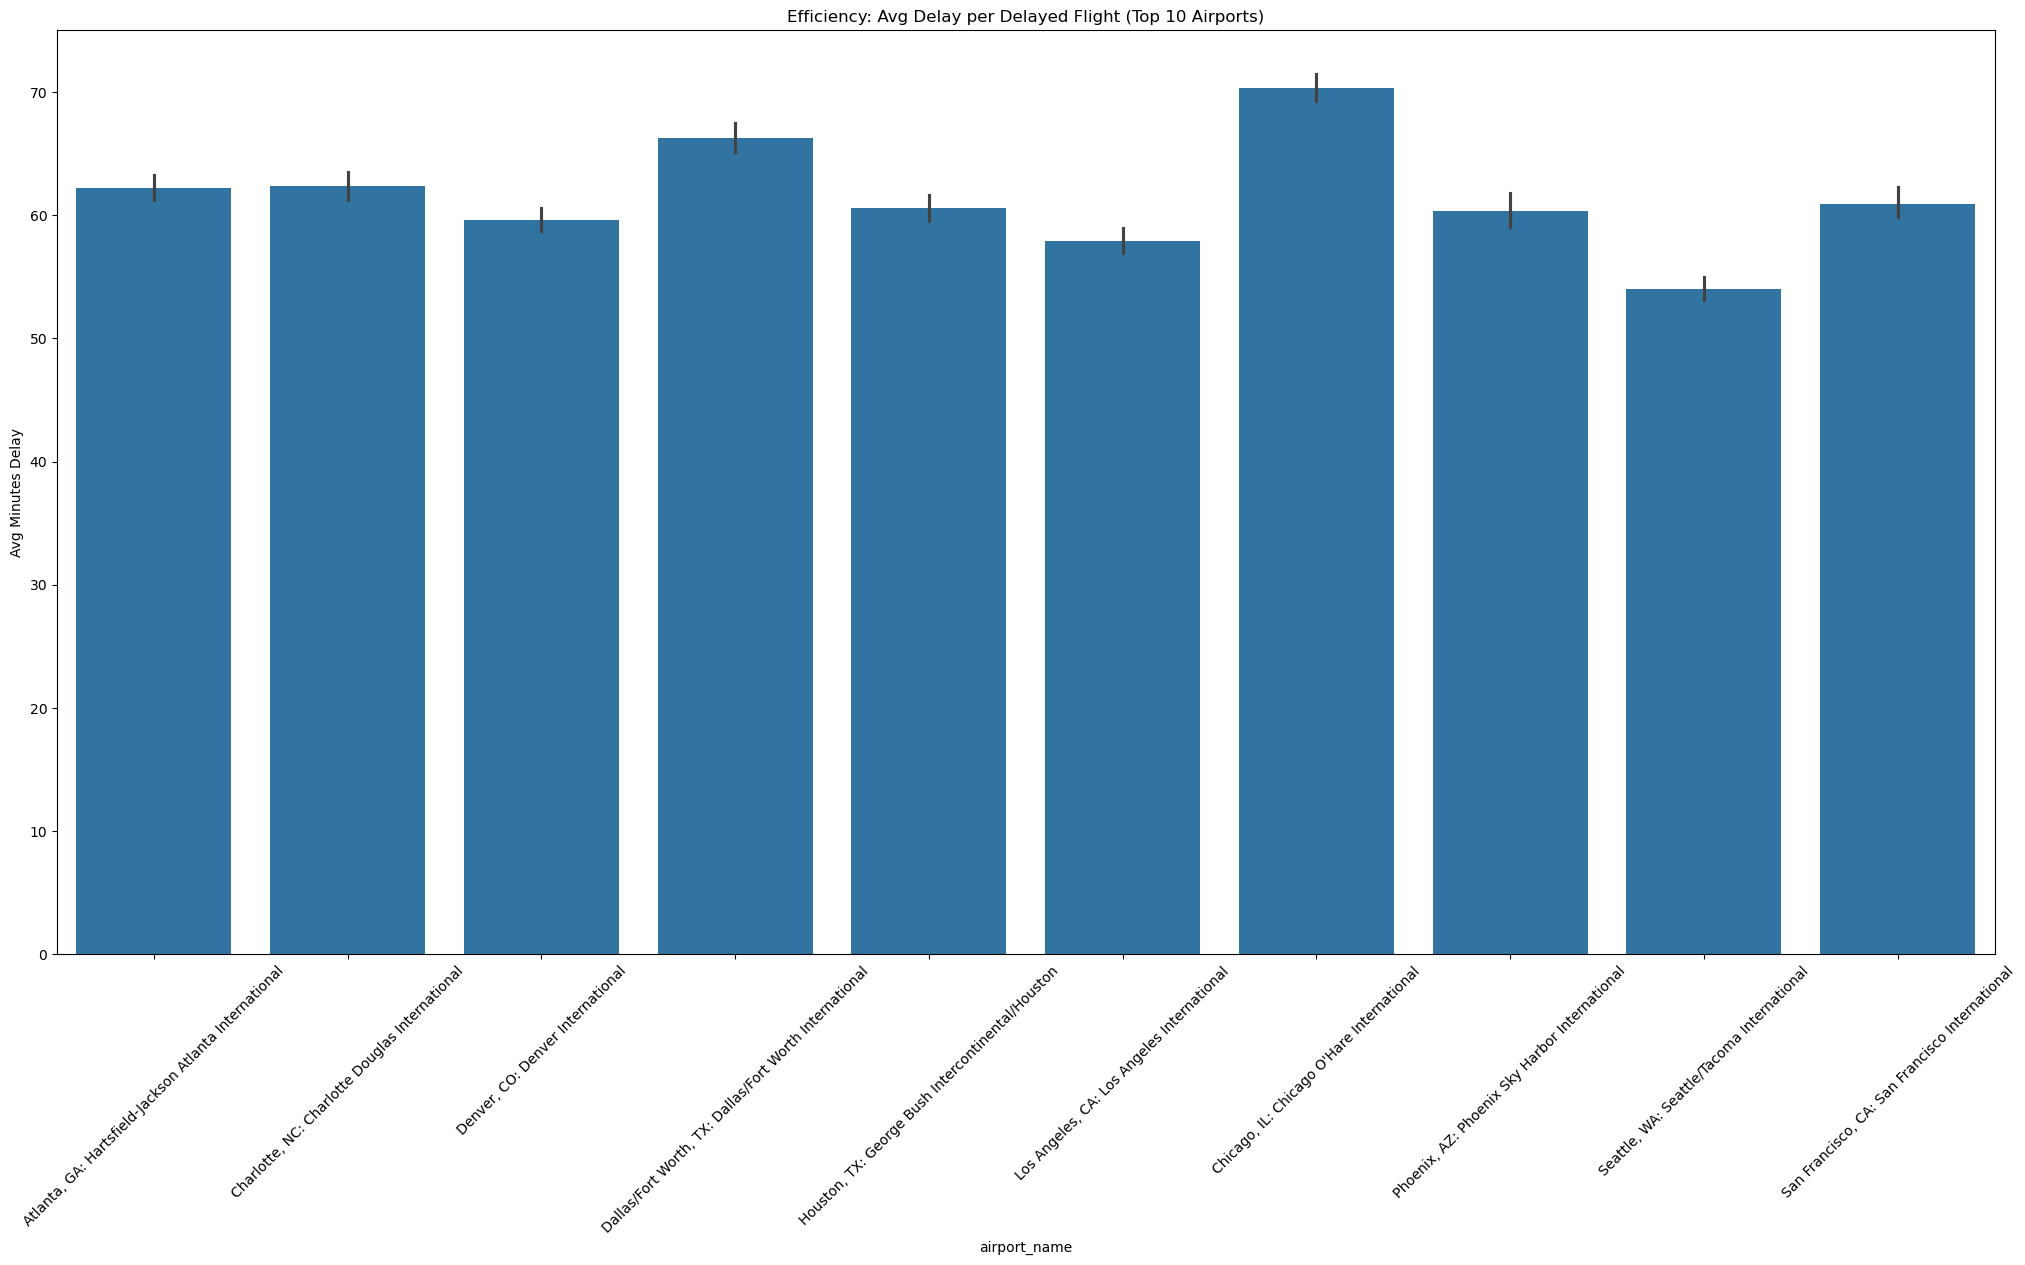

In [22]:
plt.figure(figsize=(25,12))
sns.barplot(
    data=df[df["airport_name"].isin(top_airports)],
    x="airport_name", y="avg_delay_per_delayed_flight"
)
plt.xticks(rotation=45)
plt.title("Efficiency: Avg Delay per Delayed Flight (Top 10 Airports)")
plt.ylabel("Avg Minutes Delay")
plt.show()